In [1]:
#SEP test

In [2]:
%matplotlib inline
import numpy as np
import sep
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from astropy import wcs
from math import *
from matplotlib.patches import Ellipse

# Functions

In [3]:
# returns the indices of a list in descending order
def sort_reverse_index(x):
        return sorted(range(len(x)), key=lambda k: x.max()-x[k])
#returns indices of list in ascending order
def sort_index(x):
  return sorted(range(len(x)), key=lambda k: x[k])

In [4]:
#imports fits and puts into numpy array
def load_fits(filename):
    hdu_list = fits.open(filename, do_not_scale_image_data=True)
    tbdat = hdu_list[0].data
    tbdat = tbdat.byteswap().newbyteorder()
    return tbdat

In [5]:
#cuts the exposure images to 2000X2000, as the mosaic is just 2000X2000
def cut_exp(tbdat):
    tbdat = np.delete(tbdat, list(range(2000, 2036)),0)
    tbdat = np.delete(tbdat, list(range(2000, 2036)),1)
    return tbdat

The zero function finds the "zero point". The zero point it the magnitude of an object that produces one count per second. This value 'ABMAG' pulled from the fits header information.

In [6]:
#function gives zero point from exposure 1. All exposures should have the same zero point.
def zero(filename):
    hdu_list = fits.open(filename, do_not_scale_image_data=True)
    zero_point = hdu_list[0].header['ABMAG']
    return zero_point

In [7]:
#subtracts background from image
def subtraction(tbdat, bkg):
    bkg_rms = bkg.rms()	#background noise as 2d array
    tbdat_sub = tbdat - bkg #subtract background
    return tbdat_sub

The extraction function below performs the actual extraction on the image from which the background has been subtracted. There are several options that can be input here. They are:
    * Thresh - The detection threshold. A detected object is distinguished at this threshold (e.g 5.0*err).
    * err - In the below example is the global rms. 

In [8]:
#perform the extraction
def extraction(tbdat_sub, bkg):
    objects = sep.extract(tbdat_sub, thresh = 5.0, err = bkg.globalrms)
    return objects

The kron_info function below returns the Kron radius within an ellipse and any flags associated. The Kron radius is defined by Barbary (2016) as:
$$\sum_{i} r_{i}I(r_{i})/\sum_{i}I(r_{i})$$,
where $r_{i}$ is the distance to the pixel from the ellipse. The Kron aperature photometry is a proposed technique that captures the majority of the flux. $r$ in the function is the ellipse radius which is integrated over. 


In [9]:
#Gets kron radius information
def kron_info(objects, tbdat_sub):
    kronrad, kronflag = sep.kron_radius(tbdat_sub, objects['x'], objects['y'], objects['a'], objects['b'], objects['theta'], r=6.0)
    return kronrad, kronflag


The find_flux function below finds the flux, flux errors, and extraction flags from the background subtracted image. An elliptical apeture is used unless the $kr\sqrt{a * b}$ is smaller than a given radius, where kr, a, and b are the kron radius, semi-major, and semi-minor axes respectively. Then a circular appature is used. 

The sum_ellipse and sum_circle functions utalize the following inputs:
    * r - Scaling factor for a and b
    * subpix - subpixel sampling?
The flux error is calculated by
$$ \sigma^{2}_{F} = \sum_{i}\sigma^{2}_{i} + F/g$$
where $\sigma_i$ is the pixel noise, F is the sum in the aperature, and g is the gain.

The process of finding the Kron radius, performing elliptical aperature phtometry, and then circular aperture photomety (if kr is too small) is equivilent to FLUX_AUTO in SExtractor.
    
The flux_radius function returns the radius of a circle enclosing fraction of total flux (analogous to Kron radius for ellipse?). Inputs include:
    * frac - Requested fraction of light (0-1). E.g. frac=0.5 would give the radius of a circle contining half the      total flux of the object.
    * rmax - Max radius to analyze
    * normflux - a normalizing flux, rmax is used if not given
    
The winpos function returns paramteres used to get more accurate object centroid. From documentation: "On each iteration, the centroid is calculated using all pixels within a circular aperture of 4*sig from the current position, weighting pixel positions by their flux and the amplitude of a 2-d Gaussian with sigma sig. Iteration stops when the change in position falls under some threshold or a maximum number of iterations is reached." Sigma for the Gaussian is 2.0 / (2.35 * half light radius). 

In [10]:
#Finds flux, flux error, and extraction flags
def find_flux(tbdat_sub, bkg, objects, kronrad, kronflag):
    flux, fluxerr, flag = sep.sum_ellipse(tbdat_sub, objects['x'], objects['y'], objects['a'], objects['b'], objects['theta'], r = (2.5*kronrad), err = bkg.globalrms, subpix=1)
    flag |=kronflag #combines all flags
    r_min = 1.75 #minimum diameter = 3.5
    use_circle = kronrad * np.sqrt(objects['a'] * objects['b']) < r_min
    cflux, cfluxerr, cflag = sep.sum_circle(tbdat_sub, objects['x'][use_circle], objects['y'][use_circle], r_min, subpix=1)
    flux[use_circle] = cflux
    fluxerr[use_circle] = cfluxerr
    flag[use_circle] = cflag
    r, rflag = sep.flux_radius(tbdat_sub, objects['x'], objects['y'], rmax = 6.0*objects['a'], frac = 0.5, normflux = flux, subpix =5)
    sig = 2.0 / (2.35*r) # r from sep.flux_radius() above, with fluxfrac = 0.5
    xwin, ywin, wflag = sep.winpos(tbdat_sub, objects['x'], objects['y'], sig)
    return flux, fluxerr, flag, r, xwin, ywin


In [11]:
#convert extraction flux to AB magnitude
def magnitude(flux, zero_point):
#   flux = (flux * 1.841159e-20 / 10.7367601)/3.0e18
    mag = -2.5*np.log10(flux) + zero_point
    return mag

In [12]:
#reads in catalog used to generated exposures and puts info into arrays
def read_cat(filename):
    f = open(filename, "r")
    line = f.readlines()[1:]
    f.close()
    num_cat = np.array([])
    ra_cat = np.array([])
    dec_cat = np.array([])
    mag_cat = np.array([])
    z_cat = np.array([])
    s_cat = np.array([])
    a_cat = np.array([])
    b_cat = np.array([])
    theta_cat = np.array([])
    for i in range(len(line)):
        num_cat = np.append(num_cat, int(line[i].split()[0]))
        ra_cat = np.append(ra_cat, float(line[i].split()[1]))
        dec_cat = np.append(dec_cat, float(line[i].split()[2]))
        mag_cat = np.append(mag_cat, float(line[i].split()[3]))
        z_cat = np.append(z_cat, float(line[i].split()[4]))
        a_cat = np.append(a_cat, float(line[i].split()[5]))
        b_cat = np.append(b_cat, float(line[i].split()[6]))
        theta_cat = np.append(theta_cat, float(line[i].split()[7]))
        s_cat = np.append(s_cat, float(line[i].split()[9]))
    return num_cat, ra_cat, dec_cat, mag_cat, z_cat, s_cat, a_cat, b_cat, theta_cat

In [13]:
#convert pixel location of objectes extracted from image to ra and dec
def world(filename, objects):
    hdu_list = fits.open(filename)
    w = wcs.WCS(hdu_list[0].header)
    hdu_list.close()
    wrd = w.wcs_pix2world(objects['x'], objects['y'], 0) #double check this!!!!!
    ra = wrd[:][0]
    dec = wrd[:][1]
    return ra, dec

In [14]:
#convert pixel location of corners of image to ra and dec
def world_area(filename, tbdat):
    hdu_list = fits.open(filename)
    w = wcs.WCS(hdu_list[0].header)
    hdu_list.close()
    world_min = w.wcs_pix2world(0,0,0)
    world_max = w.wcs_pix2world(len(tbdat), len(tbdat), 0)
    return world_min, world_max

# Exposure 1 Extraction

In [15]:
fname_exp1 = 'simple_sim_cube_F090W_487_01.slp.fits'
tbdat_exp1 = load_fits(fname_exp1)
tbdat_exp1 = cut_exp(tbdat_exp1)
tbdat_exp1 = np.ascontiguousarray(tbdat_exp1) #Converts cut array to C-order memory
zero_point = zero(fname_exp1)
bkg_exp1 = sep.Background(tbdat_exp1) #measures background
tbdat_sub_exp1 = subtraction(tbdat_exp1, bkg_exp1)
objects_exp1 = extraction(tbdat_sub_exp1, bkg_exp1) #extraction
print('number of exposure 1 sources', len(objects_exp1['x']))
kronrad_exp1, kronflag_exp1 = kron_info(objects_exp1, tbdat_sub_exp1)
flux_exp1, fluxerr_exp1, flag_exp1, r_exp1, xwin_exp1, ywin_exp1= find_flux(tbdat_sub_exp1, bkg_exp1, objects_exp1, kronrad_exp1, kronflag_exp1) #photometry
mag_exp1 = magnitude(flux_exp1, zero_point) #Converts flux to AB Magnitude

('number of exposure 1 sources', 65)


# Exposure 4 Extraction

In [16]:
fname_exp4 = 'simple_sim_cube_F090W_487_04.slp.fits'
tbdat_exp4 = load_fits(fname_exp4)
tbdat_exp4 = cut_exp(tbdat_exp4)
tbdat_exp4 = np.ascontiguousarray(tbdat_exp4) #Converts cut array to C-order memory
bkg_exp4 = sep.Background(tbdat_exp4) #measures background
tbdat_sub_exp4 = subtraction(tbdat_exp4, bkg_exp4)
objects_exp4 = extraction(tbdat_sub_exp4, bkg_exp4) #extraction
print('number of exposure 4 sources', len(objects_exp4['x']))
kronrad_exp4, kronflag_exp4 = kron_info(objects_exp4, tbdat_sub_exp4)
flux_exp4, fluxerr_exp4, flag_exp4, r_exp4, xwin_exp4, ywin_exp4= find_flux(tbdat_sub_exp4, bkg_exp4, objects_exp4, kronrad_exp4, kronflag_exp4) #photometry
mag_exp4 = magnitude(flux_exp4, zero_point) #Converts flux to AB Magnitude

('number of exposure 4 sources', 65)


# Mosaic Image Extraction

In [17]:
fname_img =  'F090W.fits'
tbdat = load_fits(fname_img)
bkg = sep.Background(tbdat) #measures background
tbdat_sub = subtraction(tbdat, bkg)
objects = extraction(tbdat_sub, bkg) #extraction of mosaic image
objects = objects[1:]
print('number of mosaic sources', len(objects['x']))
kronrad, kronflag = kron_info(objects, tbdat_sub) #Finds Kron Radius
flux, fluxerr, flag, r, xwin, ywin= find_flux(tbdat_sub, bkg, objects, kronrad, kronflag) #Finds flux from aperature phot.
mag = magnitude(flux, zero_point)

('number of mosaic sources', 153)


# Catalog Information

In [18]:
num_cat, ra_cat, dec_cat, mag_cat, z, s, a_cat, b_cat, theta_cat= read_cat('candels_with_fake_mag.cat')

# Get WCS Info of All Objects Extracted from Exposures and Mosaic

In [19]:
ra_exp1, dec_exp1 = world(fname_exp1, objects_exp1)
ra_exp4, dec_exp4 = world(fname_exp4, objects_exp4)
ra, dec = world(fname_img, objects)

# Get RA & DEC of Exposure Area

In [20]:
world_min_exp1, world_max_exp1 = world_area(fname_exp1, tbdat_exp1)
world_min_exp4, world_max_exp4 = world_area(fname_exp4, tbdat_exp4)
world_min, world_max = world_area(fname_img, tbdat)

# Plot exposure 1 image and catlog over

Extent in imshow is "The location, in data-coordinates, of the lower-left and upper-right corners." Done as extent=[horizontal_min,horizontal_max,vertical_min,vertical_max]. 

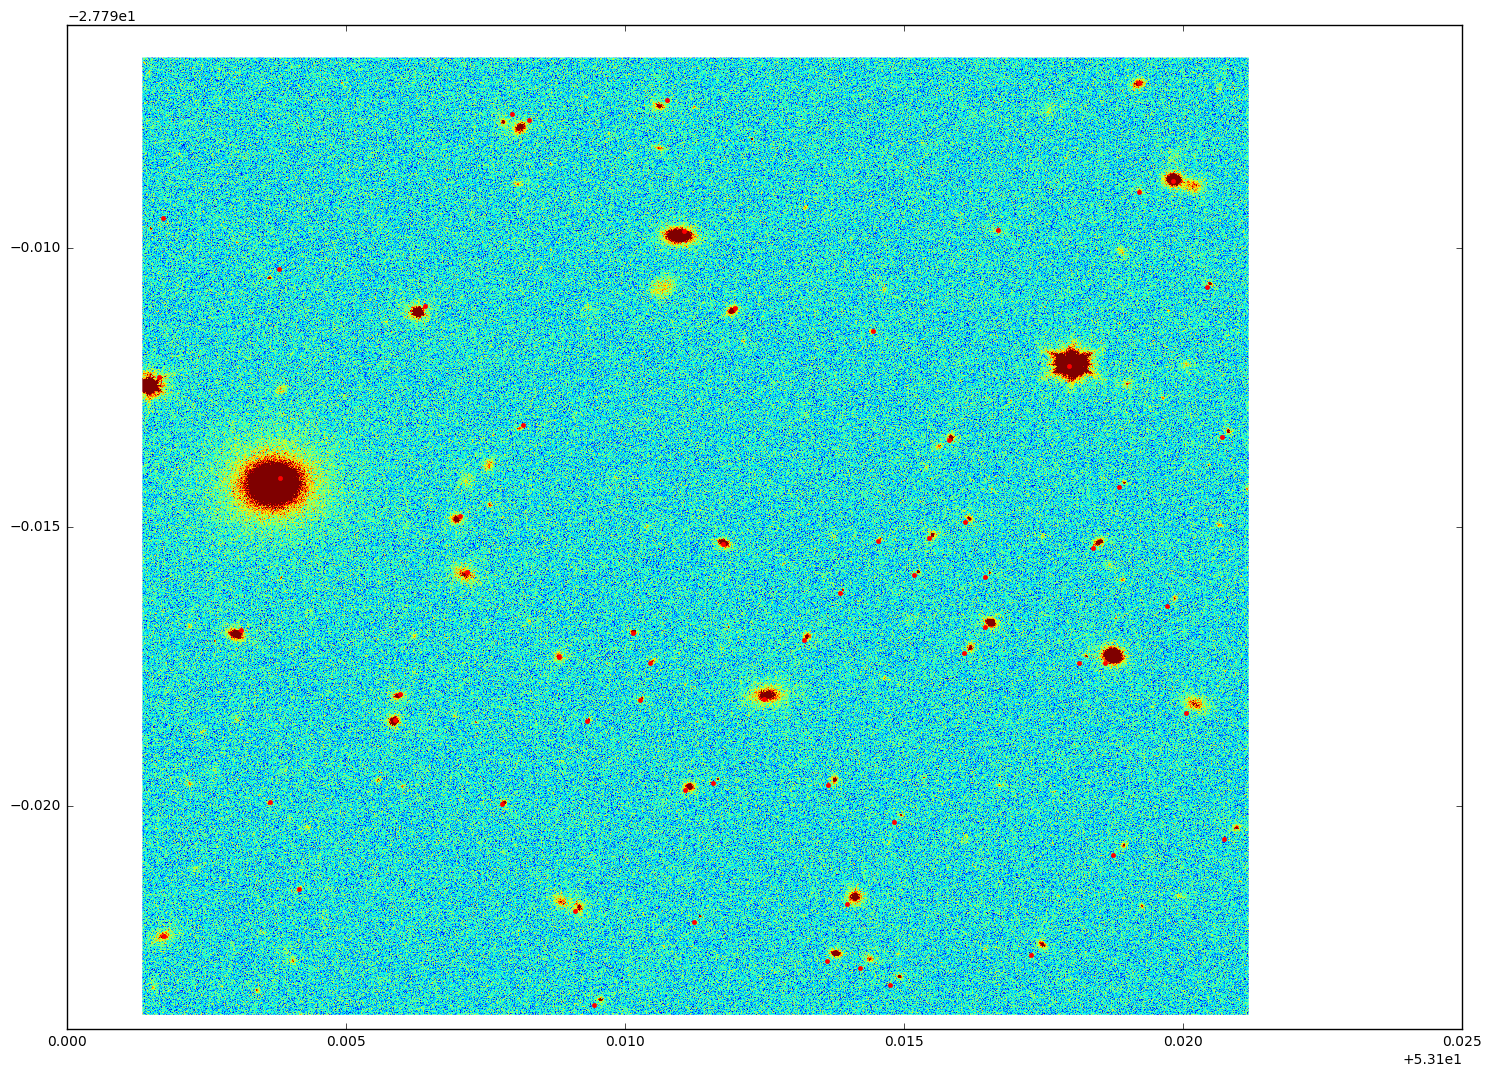

In [21]:
fig=plt.figure(figsize=(18, 16))
plt.imshow(tbdat_exp1, vmin=0.093537331, vmax=0.21167476, interpolation='none', origin='lower', extent = [world_min_exp1[0], world_max_exp1[0], world_min_exp1[1], world_max_exp1[1]])
plt.plot(ra_exp1, dec_exp1, '.', color = 'red')
#plt.plot(ra_cat, dec_cat, '.', color ='white')   

# Delete cat sources outside of exposure 1 area

Ok,I will delete catalog values with ra/dec outside of exposure

In [22]:
ra_cat_new = np.asarray([])
dec_cat_new = np.asarray([])
mag_cat_new = np.asarray([])
a_cat_new = np.asarray([])
b_cat_new = np.asarray([])
theta_cat_new = np.asarray([])
for i in range(len(ra_cat)):
    if (ra_cat[i] >= world_min_exp1[0]) and (ra_cat[i] <= world_max_exp4[0]):
        ra_cat_new = np.append(ra_cat_new, ra_cat[i])
        dec_cat_new = np.append(dec_cat_new, dec_cat[i])
        mag_cat_new = np.append(mag_cat_new, mag_cat[i])
        a_cat_new = np.append(a_cat_new, a_cat[i])
        b_cat_new = np.append(b_cat_new, b_cat[i])
        theta_cat_new = np.append(theta_cat_new, theta_cat[i])
ra_cat_cut = np.asarray([])
dec_cat_cut = np.asarray([])
mag_cat_cut = np.asarray([])
a_cat_cut = np.asarray([])
b_cat_cut = np.asarray([])
theta_cat_cut = np.asarray([])
for j in range(len(ra_cat_new)):
    if (dec_cat_new[j] >= world_min_exp1[1]) and (dec_cat_new[j] <= world_max_exp4[1]):
        ra_cat_cut = np.append(ra_cat_cut, ra_cat_new[j])
        dec_cat_cut = np.append(dec_cat_cut, dec_cat_new[j])
        mag_cat_cut = np.append(mag_cat_cut, mag_cat_new[j])
        a_cat_cut = np.append(a_cat_cut, a_cat_new[j])
        b_cat_cut = np.append(b_cat_cut, b_cat_new[j])
        theta_cat_cut = np.append(theta_cat_cut, theta_cat_new[j])

# List Brightest 100 Catalog Sources

In [23]:
#prints souces in magnitude decreasing order with corresponding ra/dec (highest 50 flux)
hdu_list = fits.open(fname_exp1)
w = wcs.WCS(hdu_list[0].header)
hdu_list.close()
index_cat = sort_index(mag_cat_cut)
#pix_exp1x = np.asarray([])
#pix_exp1y = np.asarray([])
#for n in range(len(mag_cat_cut)):
#    x = w.wcs_world2pix(ra_cat_cut[n], dec_cat_cut[n], 0)
#    pix_exp1x = np.append(pix_exp1x, x[0])
#    pix_exp1y = np.append(pix_exp1y, x[1])
#index_cat = sort_index(pix_exp1x)
print "ABMag", "\t", "x", "\t\t", "y", "\t\t", "RA", "\t\t", "DEC"
for j in range(0,50):
    k = index_cat[j]
    pix_exp1 = w.wcs_world2pix(ra_cat_cut[k], dec_cat_cut[k], 1)
    print mag_cat_cut[k], "\t", pix_exp1[0], "\t", pix_exp1[1], "\t", ra_cat_cut[k], "\t", dec_cat_cut[k] 
#    print mag_cat_cut[k], "\t", pix_exp1x[k], "\t", pix_exp1y[k], "\t", ra_cat_cut[k], "\t", dec_cat_cut[k] 

ABMag 	x 		y 		RA 		DEC
17.962 	1686.86032371 	1366.69408915 	53.118019 	-27.802065
18.292 	243.784684118 	1115.90659985 	53.103878 	-27.804071
19.217 	18.7498349689 	1322.03074613 	53.101707 	-27.80225
20.93 	504.854206587 	1475.29786231 	53.10648 	-27.800976
21.017 	1761.04910599 	757.204189145 	53.11866 	-27.807377
21.107 	977.070662854 	1634.78771796 	53.111118 	-27.799646
21.773 	1136.67652762 	674.572218769 	53.112545 	-27.80802
21.824 	1871.09116149 	1751.64796312 	53.119873 	-27.798738
22.346 	1539.92415933 	826.638912161 	53.116508 	-27.806746
22.449 	461.563821855 	621.308550255 	53.105938 	-27.808401
22.652 	589.894494074 	926.881259267 	53.107235 	-27.805758
22.655 	176.038735526 	801.873997465 	53.103172 	-27.806795
22.716 	1294.86319757 	253.257555513 	53.114033 	-27.811705
22.773 	995.769222056 	483.187618138 	53.111141 	-27.809668
22.816 	1909.57653603 	656.296129039 	53.120098 	-27.808273
22.832 	1057.28469928 	992.514969673 	53.111813 	-27.805244
23.021 	947.405956897

# List Brightest 50 Sources From Exposure 1

In [24]:
#prints souces in magnitude decreasing order with corresponding ra/dec (highest 50 flux)
index_exp1 = sort_index(mag_exp1)
#index_exp1 = sort_index(objects['x'])
print "ABMag", "\t\t", "x", "\t\t", "y", "\t\t" "RA", "\t", "\t", "DEC"
for j in range(50):
    k = index_exp1[j]
    print mag_exp1[k], "\t", objects['x'][k], "\t", objects['y'][k], "\t", ra_exp1[k], "\t", dec_exp1[k]

ABMag 		x 		y 		RA 		DEC
18.4415228856 	1902.60280118 	649.133612086 	53.1179574558 	-27.8021195132
18.7065962757 	807.182544936 	616.452775807 	53.1038183746 	-27.8041249806
19.4838525442 	903.63199239 	660.57804404 	53.1016501506 	-27.8023051038
21.0913931593 	1371.56358574 	416.948536093 	53.1186006906 	-27.8074305108
21.1447529598 	1341.08762177 	703.132011088 	53.1064199277 	-27.8010300717
21.1707127043 	1754.12212308 	750.013939235 	53.1110554979 	-27.7996996414
21.8053242856 	490.928633769 	791.242265774 	53.11981293 	-27.7987912468
21.9654919286 	1773.82891334 	353.386735828 	53.1124865547 	-27.8080725917
22.5401400787 	85.867068149 	482.367972787 	53.1164494615 	-27.8067992731
22.6151684464 	1876.53633006 	247.784414605 	53.1058799349 	-27.8084555674
22.7235292532 	470.133221583 	476.583970967 	53.1031147614 	-27.8068501794
22.8889485026 	1253.52806399 	127.922886291 	53.1139734554 	-27.8117572287
22.9812680571 	130.477593184 	511.00851426 	53.1117531116 	-27.8052961565
23.070

# Compare info about brightest source in catalog and exposure 1

In [25]:
pix_scale = 0.0317
index_cat = sort_index(mag_cat_cut)
bright_cat = index_cat[0]
elip_cat = 1 - (b_cat_cut[bright_cat]/a_cat_cut[bright_cat])
print "CATALOG:"
print "AB_mag", "\t", "RA", "\t", "DEC", "\t\t", "a(arcsec)", "\t", "b(arcsec)", "\t", "ellipticity", "\t", "theta", "\t"
print mag_cat_cut[bright_cat], "\t", round(ra_cat_cut[bright_cat],3), "\t", round(dec_cat_cut[bright_cat],3), "\t", a_cat_cut[bright_cat], "\t\t", b_cat_cut[bright_cat], "\t\t", elip_cat, "\t\t",  theta_cat_cut[bright_cat]
print
bright_exp1 = index_exp1[0]
a_exp1 = objects_exp1['a'][bright_exp1]*pix_scale #convert from pix units to arc sec
b_exp1 = objects_exp1['b'][bright_exp1]*pix_scale
theta_exp1 = objects_exp1['theta'][bright_exp1]
elip_exp1 = 1 - (b_exp1/a_exp1)
print "Exposure 1"
print "AB_mag", "\t", "RA", "\t", "DEC", "\t\t", "a(arcsec)", "\t", "b(arcsec)", "\t", "ellipticity", "\t", "theta", "\t"
print round(mag_exp1[bright_exp1],3), "\t", round(ra_exp1[bright_exp1],3), "\t", round(dec_exp1[bright_exp1],3), "\t", round(a_exp1,2), "\t\t", round(b_exp1,3), "\t\t", round(elip_exp1,3), "\t\t", round(theta_exp1*180./np.pi,3)
print
print "flags:"
print objects_exp1['flag'][bright_exp1]

CATALOG:
AB_mag 	RA 	DEC 		a(arcsec) 	b(arcsec) 	ellipticity 	theta 	
17.962 	53.118 	-27.802 	0.036 		0.033 		0.0833333333333 		-29.698

Exposure 1
AB_mag 	RA 	DEC 		a(arcsec) 	b(arcsec) 	ellipticity 	theta 	
18.442 	53.118 	-27.802 	0.22 		0.193 		0.113 		-8.572

flags:
0


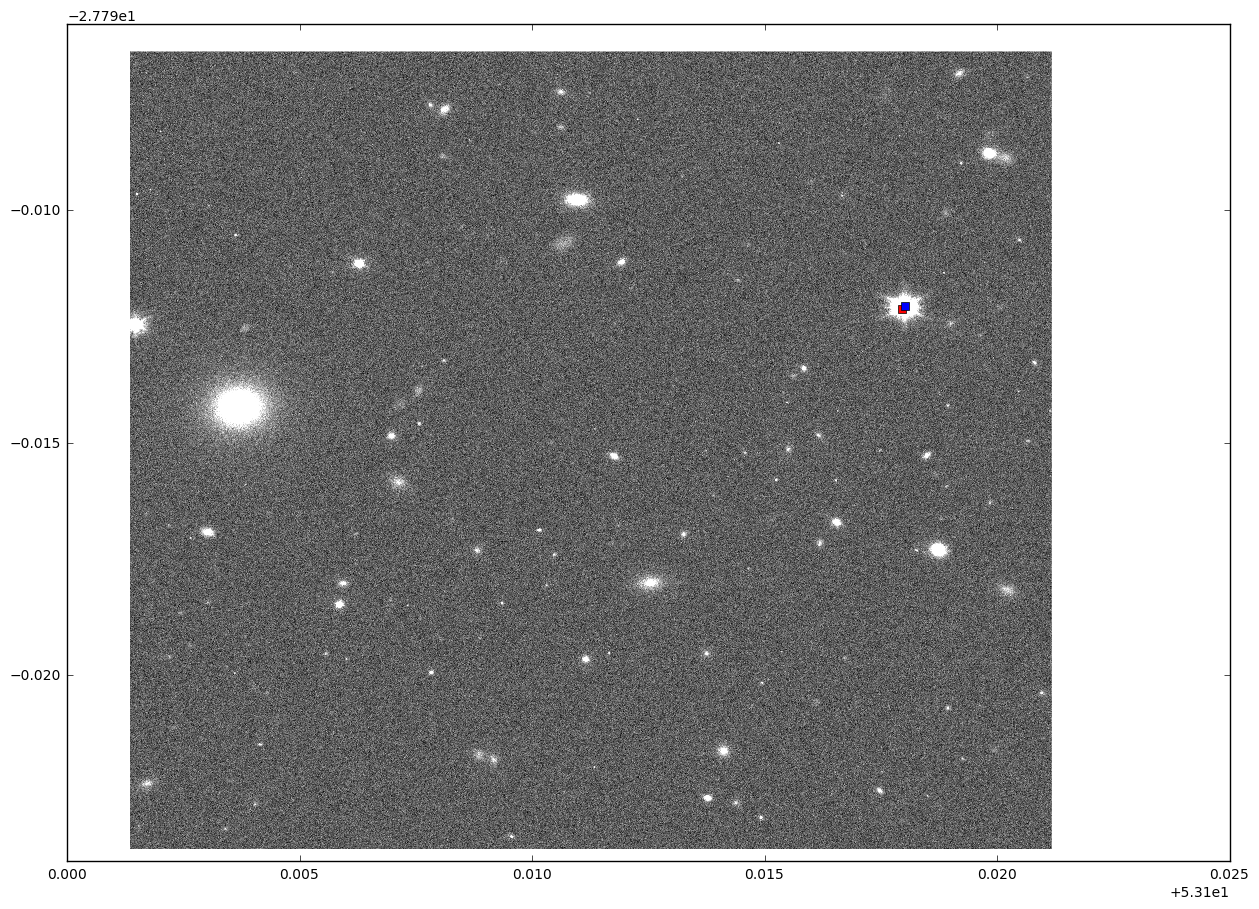

In [26]:
fig, ax =plt.subplots(figsize=(15, 15))
im = ax.imshow(tbdat_exp1, vmin=0.093537331, vmax=0.21167476, cmap = 'gray', interpolation='none', origin='lower', extent = [world_min_exp1[0], world_max_exp1[0], world_min_exp1[1], world_max_exp1[1]])
plt.plot(ra_exp1[bright_exp1], dec_exp1[bright_exp1], marker = "s", color = 'red')
plt.plot(ra_cat_cut[bright_cat], dec_cat_cut[bright_cat], marker = "s", color = 'blue')

# Find area covered by extracted exp1 source and count up flux

In [27]:
xmin_exp1 = objects_exp1['xmin'][bright_exp1]
xmax_exp1 = objects_exp1['xmax'][bright_exp1]
ymin_exp1 = objects_exp1['ymin'][bright_exp1]
ymax_exp1 = objects_exp1['ymax'][bright_exp1]

In [28]:
length = len(tbdat_exp1[0])
tbdat_exp1_cut = np.delete(tbdat_exp1, list(range(0, xmin_exp1)),1)
tbdat_exp1_cut = np.delete(tbdat_exp1_cut, list(range(xmax_exp1-xmin_exp1, len(tbdat_exp1))), 1)
tbdat_exp1_cut = np.delete(tbdat_exp1_cut, list(range(0, ymin_exp1)),0)
tbdat_exp1_cut = np.delete(tbdat_exp1_cut, list(range(ymax_exp1-ymin_exp1, length)), 0)
print tbdat_exp1_cut.shape

(68, 69)


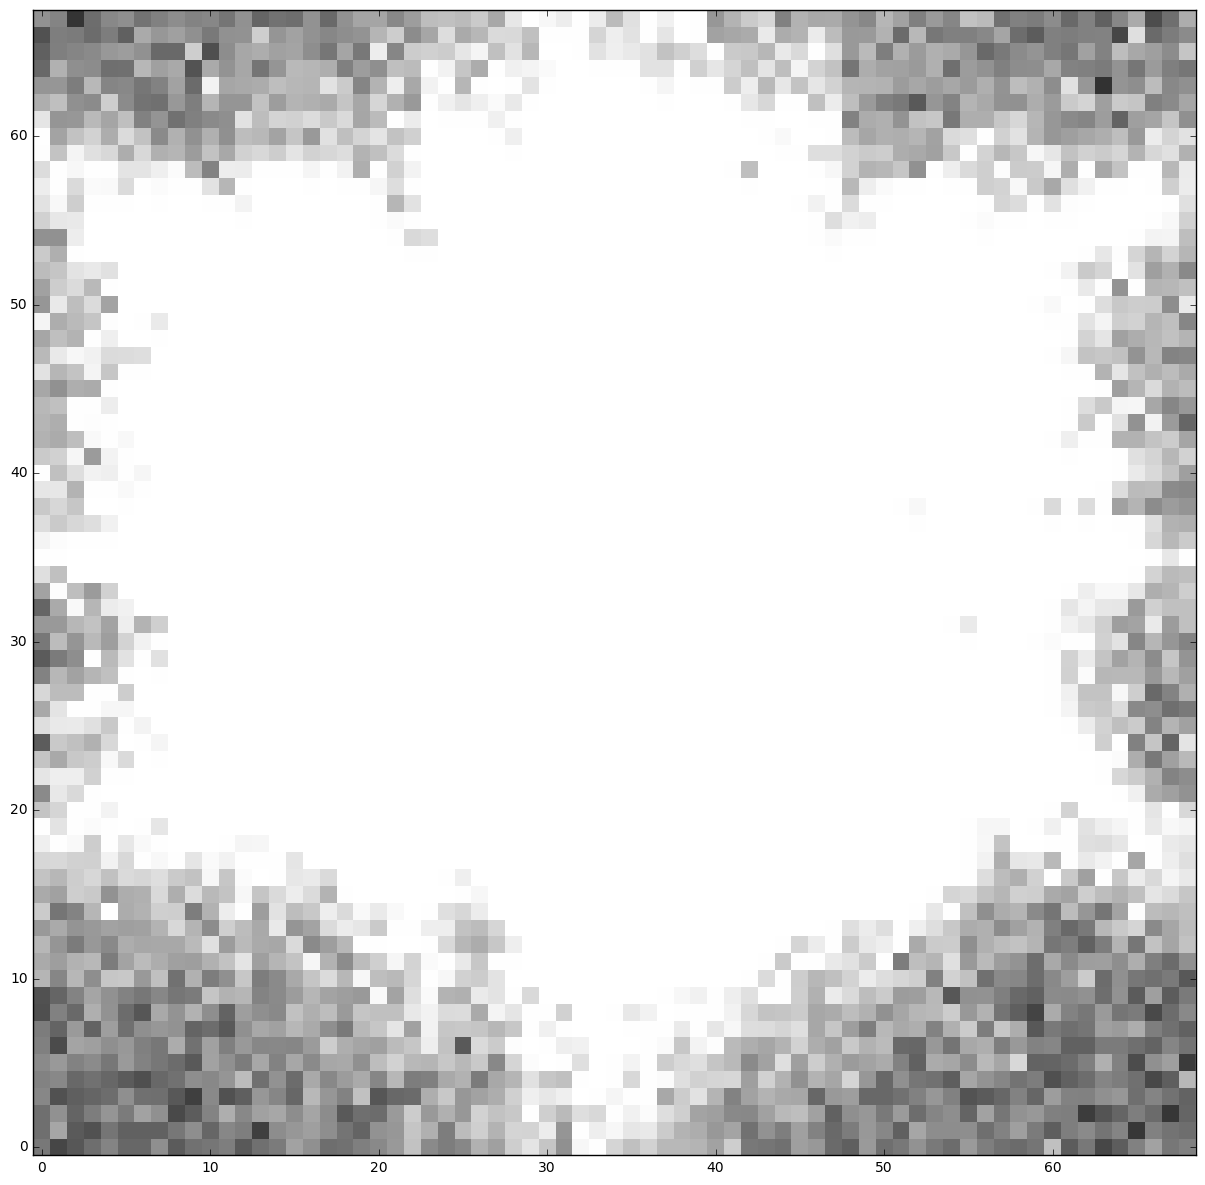

In [29]:
fig, ax =plt.subplots(figsize=(15, 15))
im = ax.imshow(tbdat_exp1_cut, cmap = 'gray',vmin=0.093537331, vmax=0.21167476, interpolation='none', origin='lower')

In [30]:
sum_exp1_bright = sum(map(sum, tbdat_exp1_cut))
print "sum of brightest extracted source:", sum_exp1_bright
print "flux from extraction:" , flux_exp1[bright_exp1]
print flux_exp1[bright_exp1] / sum_exp1_bright

sum of brightest extracted source: 4043.62326783
flux from extraction: 3051.76329869
0.754710094526


Find differences in flux

In [31]:
for j in range(50):
    k = index_exp1[j]
    n = index_cat[j]
    flux_e = 10**((mag_exp1[k]-zero_point) / -2.5)
    flux_c = 10**((mag_cat_cut[n]-zero_point)/ -2.5)
    flux_diff = flux_c - flux_e
    print flux_diff

1694.58932078
1111.67344783
325.558536467
42.6031729796
31.6014175013
14.9341836942
4.16213149537
16.5415512588
13.7057018536
10.8037450382
4.02616952566
12.2069197697
12.9046628893
13.5294968369
12.2804190746
11.963417166
10.4110736495
10.2563583366
12.8296867963
12.0653934916
15.5412246464
11.7276277589
10.9259848183
11.3438859962
10.3195001226
10.2240159241
11.0177919375
13.2494600825
12.6504319082
12.8085364916
12.3529852316
8.03118212397
7.91063929091
9.23953538818
9.52468443171
7.87320755752
7.88103260387
7.8471628785
8.76426994884
8.13093568595
8.35622490198
8.07245598266
6.90977588882
7.81036692465
7.99642078186
6.65219956889
6.65845599622
7.59236888997
7.18347142071
6.08810809093


# Plot second brightest source

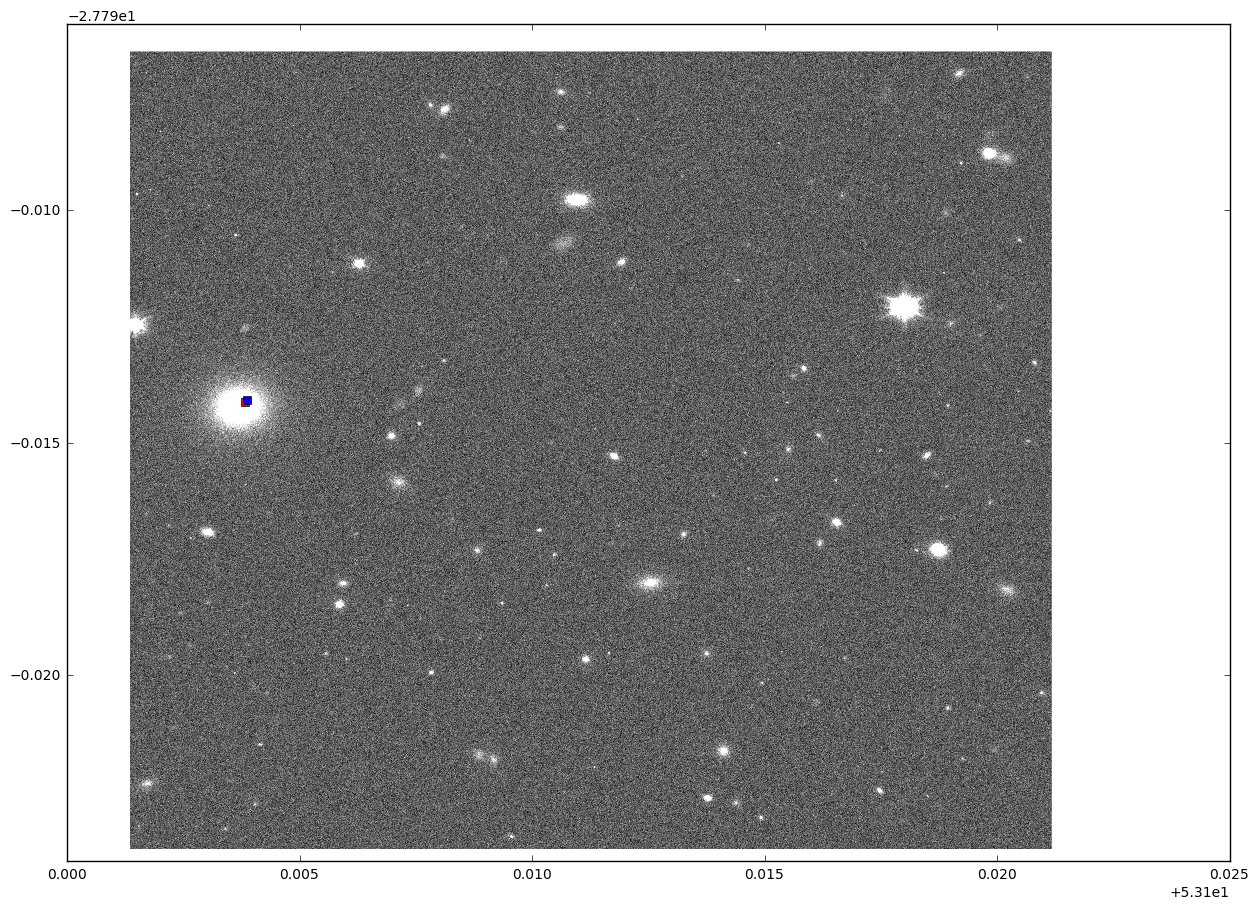

In [32]:
bright_exp1_2 = index_exp1[1]
bright_cat_2 = index_cat[1]
fig, ax =plt.subplots(figsize=(15, 15))
im = ax.imshow(tbdat_exp1, vmin=0.093537331, vmax=0.21167476, cmap = 'gray', interpolation='none', origin='lower', extent = [world_min_exp1[0], world_max_exp1[0], world_min_exp1[1], world_max_exp1[1]])
plt.plot(ra_exp1[bright_exp1_2], dec_exp1[bright_exp1_2], marker = "s", color = 'red')
plt.plot(ra_cat_cut[bright_cat_2], dec_cat_cut[bright_cat_2], marker = "s", color = 'blue')


In [33]:
pix_scale = 0.0317
elip_cat = 1 - (b_cat_cut[bright_cat_2]/a_cat_cut[bright_cat_2])
print "CATALOG:"
print "AB_mag", "\t", "RA", "\t", "DEC", "\t\t", "a(arcsec)", "\t", "b(arcsec)", "\t", "ellipticity", "\t", "theta", "\t"
print mag_cat_cut[bright_cat_2], "\t", round(ra_cat_cut[bright_cat_2],3), "\t", round(dec_cat_cut[bright_cat_2],3), "\t", a_cat_cut[bright_cat_2], "\t\t", b_cat_cut[bright_cat_2], "\t\t", round(elip_cat,3), "\t\t",  theta_cat_cut[bright_cat_2]
print
a_exp1 = objects_exp1['a'][bright_exp1_2]*pix_scale #convert from pix units to arc sec
b_exp1 = objects_exp1['b'][bright_exp1_2]*pix_scale
theta_exp1 = objects_exp1['theta'][bright_exp1_2]
elip_exp1 = 1 - (b_exp1/a_exp1)
print "Exposure 1"
print "AB_mag", "\t", "RA", "\t", "DEC", "\t\t", "a(arcsec)", "\t", "b(arcsec)", "\t", "ellipticity", "\t", "theta", "\t"
print round(mag_exp1[bright_exp1_2],3), "\t", round(ra_exp1[bright_exp1_2],3), "\t", round(dec_exp1[bright_exp1_2],3), "\t", round(a_exp1,2), "\t\t", round(b_exp1,3), "\t\t", round(elip_exp1,3), "\t\t", round(theta_exp1*180./np.pi,3)
print
print "flags:"
print objects_exp1['flag'][bright_exp1_2]

CATALOG:
AB_mag 	RA 	DEC 		a(arcsec) 	b(arcsec) 	ellipticity 	theta 	
18.292 	53.104 	-27.804 	0.836 		0.763 		0.087 		14.334

Exposure 1
AB_mag 	RA 	DEC 		a(arcsec) 	b(arcsec) 	ellipticity 	theta 	
18.707 	53.104 	-27.804 	0.49 		0.454 		0.077 		7.614

flags:
0


# Mosaic and Catalog Comparison

In [34]:
pix_scale = 0.0317
bright_cat = index_cat[0]
elip_cat = 1 - (b_cat_cut[bright_cat]/a_cat_cut[bright_cat])
print "CATALOG:"
print "AB_mag", "\t", "RA", "\t", "DEC", "\t\t", "a(arcsec)", "\t", "b(arcsec)", "\t", "ellipticity", "\t", "theta", "\t"
print mag_cat_cut[bright_cat], "\t", round(ra_cat_cut[bright_cat],3), "\t", round(dec_cat_cut[bright_cat],3), "\t", a_cat_cut[bright_cat], "\t\t", b_cat_cut[bright_cat], "\t\t", round(elip_cat,3), "\t\t",  theta_cat_cut[bright_cat]
print
index = sort_index(mag)
bright = index[0]
a = objects['a'][bright]*pix_scale #convert from pix units to arc sec
b = objects['b'][bright]*pix_scale
theta = objects['theta'][bright]
elip = 1 - (b/a)
print "Exposure 1"
print "AB_mag", "\t", "RA", "\t", "DEC", "\t\t", "a(arcsec)", "\t", "b(arcsec)", "\t", "ellipticity", "\t", "theta", "\t"
print round(mag[bright],3), "\t", round(ra[bright],3), "\t", round(dec[bright],3), "\t", round(a,2), "\t\t", round(b,3), "\t\t", round(elip,3), "\t\t", round(theta*180./np.pi,3)
print
print "flags:"
print objects['flag'][bright]

CATALOG:
AB_mag 	RA 	DEC 		a(arcsec) 	b(arcsec) 	ellipticity 	theta 	
17.962 	53.118 	-27.802 	0.036 		0.033 		0.083 		-29.698

Exposure 1
AB_mag 	RA 	DEC 		a(arcsec) 	b(arcsec) 	ellipticity 	theta 	
18.43 	53.118 	-27.802 	0.25 		0.227 		0.096 		-10.853

flags:
0


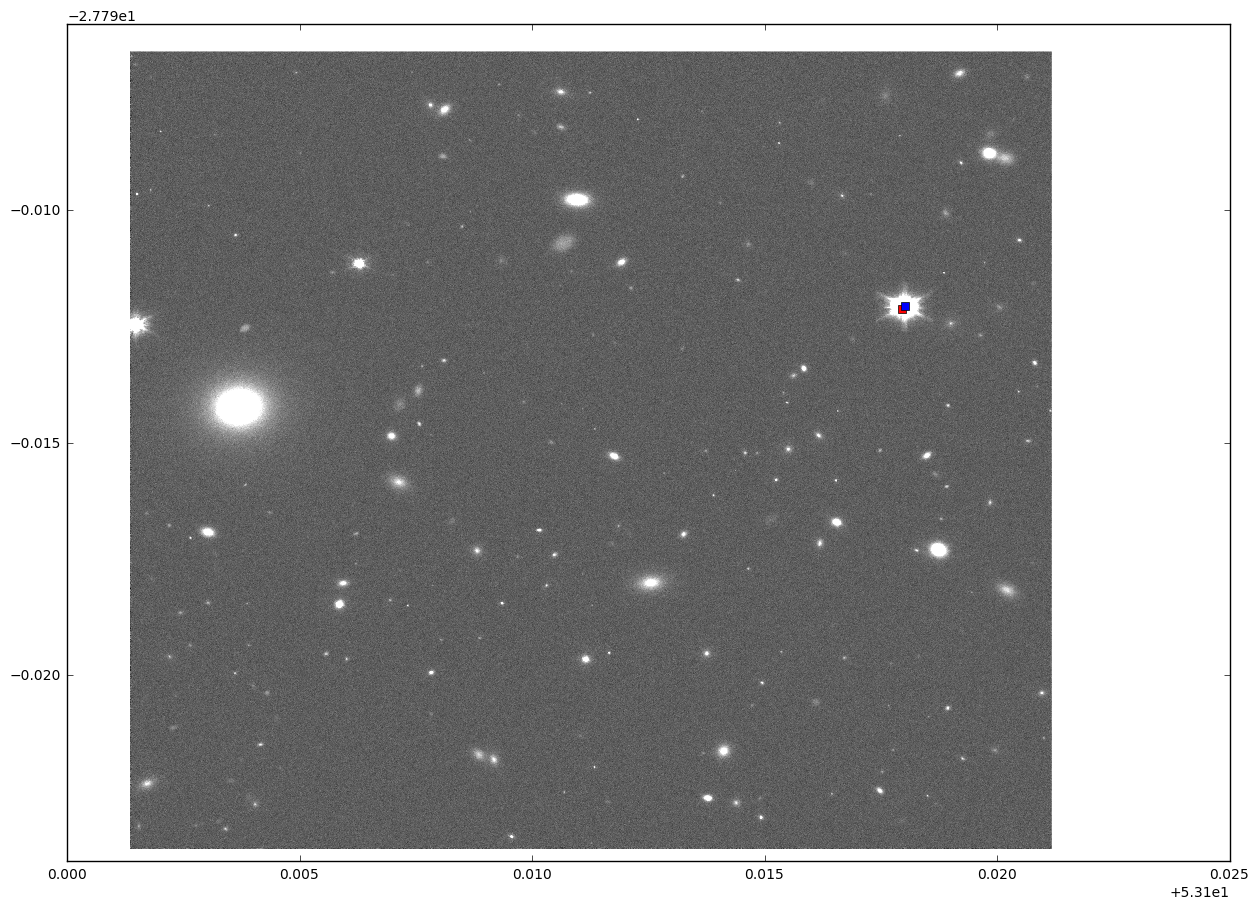

In [35]:
fig, ax =plt.subplots(figsize=(15, 15))
im = ax.imshow(tbdat, vmin=0.093537331, vmax=0.21167476, cmap = 'gray', interpolation='none', origin='lower', extent = [world_min[0], world_max[0], world_min[1], world_max[1]])
plt.plot(ra[bright], dec[bright], marker = "s", color = 'red')
plt.plot(ra_cat_cut[bright_cat], dec_cat_cut[bright_cat], marker = "s", color = 'blue')

# Just Tests below

# Find area covered by extracted mosaic source and count up flux

In [36]:
xmin = objects['xmin'][bright]
xmax = objects['xmax'][bright]
ymin = objects['ymin'][bright]
ymax = objects['ymax'][bright]

In [37]:
length = len(tbdat[0])
tbdat_cut = np.delete(tbdat, list(range(0, xmin)),1)
tbdat_cut = np.delete(tbdat_cut, list(range(xmax-xmin, len(tbdat))), 1)
tbdat_cut = np.delete(tbdat_cut, list(range(0, ymin)),0)
tbdat_cut = np.delete(tbdat_cut, list(range(ymax-ymin, length)), 0)
print tbdat_cut.shape

(97, 93)


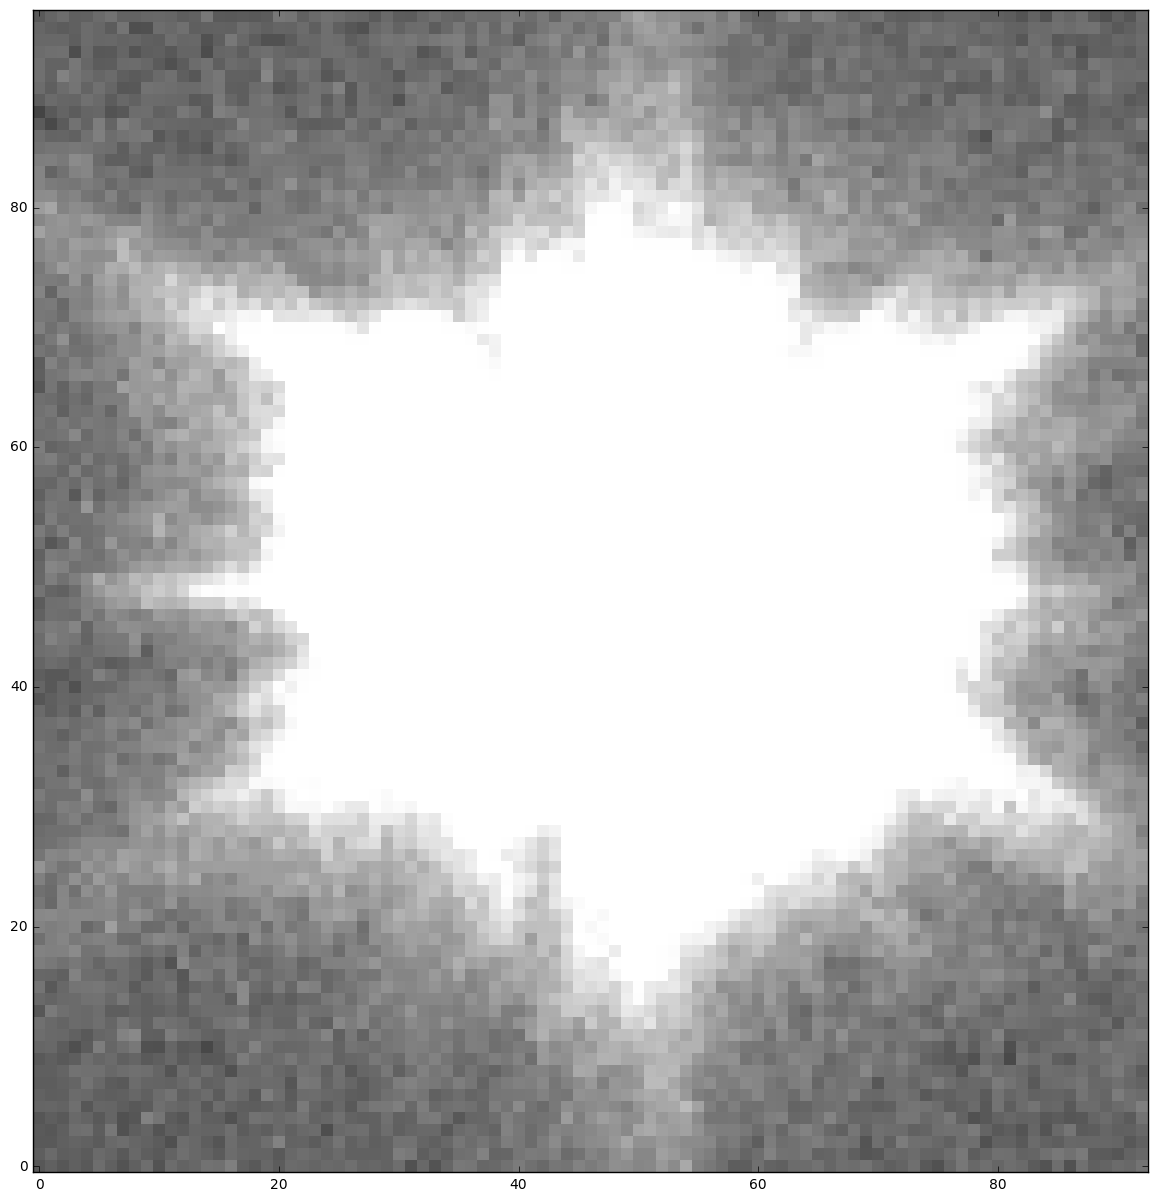

In [38]:
fig, ax =plt.subplots(figsize=(15, 15))
im = ax.imshow(tbdat_cut, cmap = 'gray',vmin=0.093537331, vmax=0.21167476, interpolation='none', origin='lower')

In [39]:
sum_bright = sum(map(sum, tbdat_cut))
print "sum of brightest extracted source:", sum_bright
print "flux from extraction:" , flux[bright]
print flux[bright] / sum_bright

sum of brightest extracted source: 4708.09856896
flux from extraction: 3085.3237593
0.65532267732
